In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
stock = yf.Ticker("AAPL") 
data = stock.history(start="2015-01-01", end="2025-01-01", auto_adjust=False) 

In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2015-01-02 00:00:00-05:00,27.847500,27.860001,26.837500,27.332500,24.320431,212818400,0.0,0.0
2015-01-05 00:00:00-05:00,27.072500,27.162500,26.352501,26.562500,23.635288,257142000,0.0,0.0
2015-01-06 00:00:00-05:00,26.635000,26.857500,26.157499,26.565001,23.637510,263188400,0.0,0.0
2015-01-07 00:00:00-05:00,26.799999,27.049999,26.674999,26.937500,23.968962,160423600,0.0,0.0
2015-01-08 00:00:00-05:00,27.307501,28.037500,27.174999,27.972500,24.889902,237458000,0.0,0.0


In [5]:
df = data.reset_index()['Close']

In [6]:
df = df.rolling(window=5).mean().dropna()

In [7]:
training_size = int(len(df)*0.8)
train_data = df[:training_size]
test_data = df[training_size:]

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
train_data_scaled = scaler.fit_transform(np.array(train_data).reshape(-1,1))
test_data_scaled = scaler.transform(np.array(test_data).reshape(-1, 1))

In [9]:
train_data_scaled 

array([[0.02618404],
       [0.02704086],
       [0.02799998],
       ...,
       [0.69948782],
       [0.69148235],
       [0.68401399]])

In [10]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [11]:
time_step = 100
X_train, y_train = create_dataset(train_data_scaled, time_step)
X_test, ytest = create_dataset(test_data_scaled, time_step)

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU, Input
from tensorflow.keras.layers import Dropout

In [14]:
model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(50))
model.add(Dropout(0.2))
model.add(Dense(1))

In [15]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam


model.compile(
    loss=Huber(delta=1.0),
    optimizer=Adam(learning_rate=0.0001),
    metrics=['mae']
)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history_a = model.fit(
    X_train, y_train,
    validation_data=(X_test, ytest),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0793 - mae: 0.2760 - val_loss: 0.1193 - val_mae: 0.4806 - learning_rate: 1.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0126 - mae: 0.1294 - val_loss: 0.0170 - val_mae: 0.1764 - learning_rate: 1.0000e-04
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0051 - mae: 0.0853 - val_loss: 0.0035 - val_mae: 0.0753 - learning_rate: 1.0000e-04
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0023 - mae: 0.0531 - val_loss: 8.4271e-04 - val_mae: 0.0331 - learning_rate: 1.0000e-04
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0018 - mae: 0.0388 - val_loss: 7.2772e-04 - val_mae: 0.0308 - learning_rate: 1.0000e-04
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0017 - mae: 0.0354 - val_loss: 7.7285e-04 - val_mae: 0.0319 - learning_rate: 1.0000e-04
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0015 - mae: 0.0329 - val_loss: 4.5164e-04 - val_ma

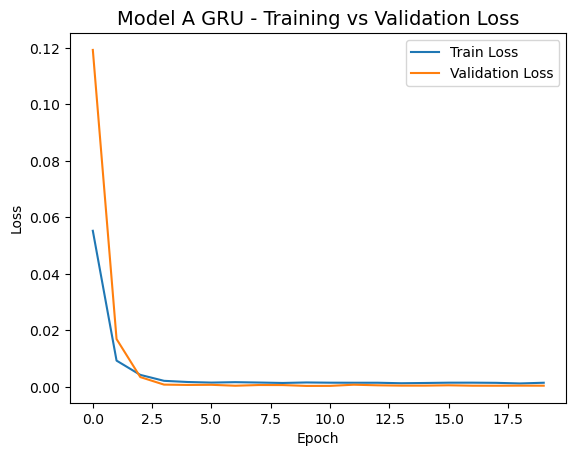

In [29]:
plt.plot(history_a.history['loss'], label='Train Loss')
plt.plot(history_a.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model A GRU - Training vs Validation Loss', fontsize=14)
plt.legend()
plt.show()

In [19]:
predictions = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [20]:
predictions = scaler.inverse_transform(predictions)

In [21]:
predictions

array([[174.24673],
       [174.35423],
       [174.40411],
       [174.47734],
       [174.66924],
       [175.07034],
       [175.70541],
       [176.49013],
       [177.31229],
       [178.0782 ],
       [178.74126],
       [179.28136],
       [179.77905],
       [180.29008],
       [180.8801 ],
       [181.56583],
       [182.31595],
       [183.05202],
       [183.7171 ],
       [184.33168],
       [184.87523],
       [185.3347 ],
       [185.7604 ],
       [186.22972],
       [186.73477],
       [187.34671],
       [188.09866],
       [188.92133],
       [189.7478 ],
       [190.51312],
       [191.06969],
       [191.3668 ],
       [191.45985],
       [191.41379],
       [191.30278],
       [191.27266],
       [191.40715],
       [191.72617],
       [192.16698],
       [192.65117],
       [193.08385],
       [193.43684],
       [193.69878],
       [193.88696],
       [194.0899 ],
       [194.35779],
       [194.67834],
       [194.96289],
       [195.15625],
       [195.02347],


In [22]:
y_test_actual = scaler.inverse_transform(ytest.reshape(-1, 1))

In [23]:
y_test_actual

array([[173.15      ],
       [173.2039978 ],
       [173.82399902],
       [174.96199951],
       [176.61199951],
       [178.2039978 ],
       [179.03399963],
       [179.41600037],
       [179.53000183],
       [179.62600403],
       [179.62800598],
       [180.47000427],
       [181.29000244],
       [182.51600037],
       [183.6039978 ],
       [184.39599609],
       [184.63999634],
       [184.76999817],
       [185.37999878],
       [185.51399841],
       [185.58399963],
       [186.19400024],
       [187.2519989 ],
       [187.76999817],
       [189.22799988],
       [190.66600037],
       [191.32000122],
       [191.83200073],
       [192.05      ],
       [190.97799988],
       [190.1019989 ],
       [189.78999939],
       [189.53599854],
       [189.53800049],
       [190.61400146],
       [191.74400024],
       [192.81000061],
       [193.32800293],
       [193.57800293],
       [193.33000183],
       [193.30800171],
       [193.18800049],
       [193.20599976],
       [193

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")

RMSE: 4.3203877413378216
MAE: 3.49953840459251
R² Score: 0.9654135471731745


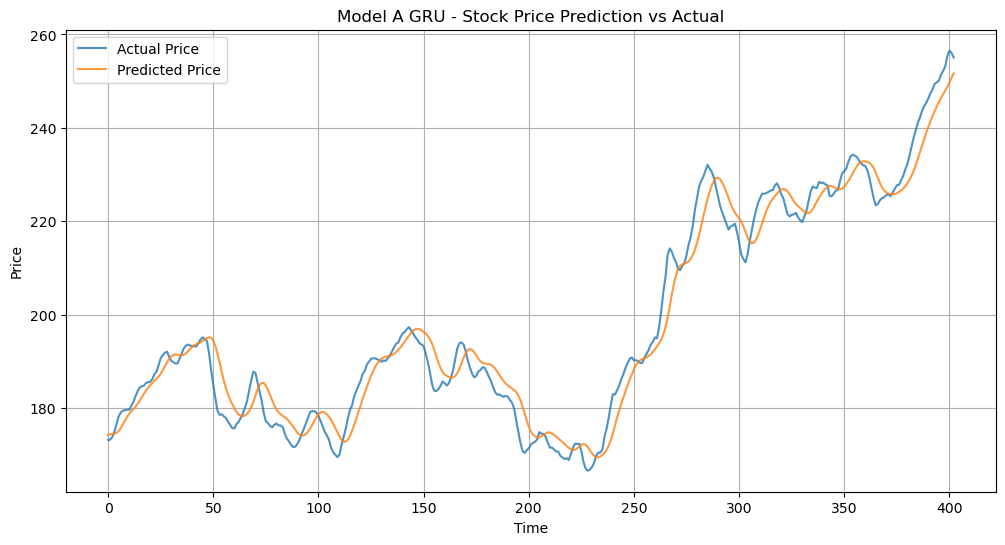

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price', alpha=0.8)
plt.plot(predictions, label='Predicted Price', alpha=0.8)
plt.title('Model A GRU - Stock Price Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
model.save('gru_2layers_.keras')